In [129]:
%config IPCompleter.greedy=True

import itertools
import os, shutil
import pandas as pd
import time
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

import cv2
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
from PIL import Image
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

TF version: 2.3.1
Hub version: 0.7.0
GPU is available


In [70]:
##### Get Voc Training Dataset
voc_dir = r"D:\voc2007"

labels = ["person", "car", "bus", "bicycle", "motorbike", "aeroplane"]

data_trainval_all = pd.DataFrame(columns=["img_id"] + labels)

# Get Dataset and put it into a table
for i in range(len(labels)):
    data_trainval = pd.read_csv(voc_dir + '\ImageSets\Main\{}_trainval.txt'.format(labels[i]),header = None,index_col=False ,delim_whitespace=True, dtype={0:np.str, 1:np.int})
    
    if(i == 0):
        data_trainval_all['img_id'] = data_trainval[0]

    data_trainval_all[labels[i]] = data_trainval[1]

# get no. objects in dataset + delete rows with no relative objects
def remove_excluded_objects(data_trainval_all, labels):

    rows_to_del_trainval = []
    dataset_trainval_counter = {x:0 for x in labels}
    
    for i in range(len(data_trainval_all.index)):
        row = data_trainval_all.iloc[i]
        counter = 0
        for label in labels:

            if(row[label] == 1):
                dataset_trainval_counter[label] += 1
            elif(row[label] == -1):
                counter += 1

        if(counter == len(labels)):
            rows_to_del_trainval.append(row['img_id'])

    for img_id in rows_to_del_trainval:

        data_trainval_all.drop(data_trainval_all.loc[data_trainval_all['img_id'] == img_id].index, inplace=True)

            
    print(dataset_trainval_counter)

def number_of_objects(data_trainval_all, labels):
    
    dataset_trainval_counter = {x:0 for x in labels}
    
    for i in range(len(data_trainval_all.index)):
        row = data_trainval_all.iloc[i]

        for label in labels:

            if(row[label] == 1):
                dataset_trainval_counter[label] += 1
            
    print(dataset_trainval_counter)

# delete rows with people to reduce bias
def decrease_class_amount(data_trainval_all, object_name, delete_amount, labels):
    rows_to_del_trainval = []

    data_trainval_object = data_trainval_all.loc[data_trainval_all[object_name] == 1]
    how_many_ofobject_to_delete = delete_amount
    deleted_object = 0
    
    for i in range(len(data_trainval_object)):
        
        if(deleted_object == how_many_ofobject_to_delete):
            break
        
        row = data_trainval_object.iloc[i]
        rows_to_del_trainval.append(row['img_id'])
        deleted_object += 1

    for img_id in rows_to_del_trainval:

        data_trainval_all.drop(data_trainval_all.loc[data_trainval_all['img_id'] == img_id].index, inplace=True)

remove_excluded_objects(data_trainval_all,labels)
# number_of_objects(data_trainval_all,labels)

decrease_class_amount(data_trainval_all, "person", 800, labels)
number_of_objects(data_trainval_all,labels)
decrease_class_amount(data_trainval_all, "car", 100, labels)
number_of_objects(data_trainval_all,labels)

# make dataset a 80/20 split

train_size = int(len(data_trainval_all.index)*0.85)
val_size = len(data_trainval_all.index) - train_size

data_train_all = data_trainval_all.iloc[:train_size]
data_val_all = data_trainval_all.iloc[train_size:]


{'person': 2008, 'car': 713, 'bus': 186, 'bicycle': 243, 'motorbike': 245, 'aeroplane': 238}
{'person': 1208, 'car': 641, 'bus': 158, 'bicycle': 179, 'motorbike': 180, 'aeroplane': 231}
{'person': 1208, 'car': 541, 'bus': 155, 'bicycle': 179, 'motorbike': 178, 'aeroplane': 230}


In [72]:
# Make a script to seperate data into subfolders

for label in labels:
    try:
        os.makedirs(voc_dir + r"\voc_submodules_train\{}".format(label))
    except FileExistsError:
        pass
    
    try:
        os.makedirs(voc_dir + r"\voc_submodules_val\{}".format(label))
    except FileExistsError:
        pass

    
for i, row in data_train_all.iterrows():
    for label in labels:
        if(row[label] == 1):
            shutil.copyfile(voc_dir + r'\JPEGImages\{}.jpg'.format(row['img_id']), 
                            voc_dir + r'\voc_submodules_train\{}\{}.jpg'.format(label, row['img_id']) )
            
for i, row in data_val_all.iterrows():
    for label in labels:
        if(row[label] == 1):
            shutil.copyfile(voc_dir + r'\JPEGImages\{}.jpg'.format(row['img_id']), 
                            voc_dir + r'\voc_submodules_val\{}\{}.jpg'.format(label, row['img_id']) )

print("Finished Splitting Subfolders")


Finished Splitting Subfolders


In [73]:
train_data_dir =voc_dir + r'\voc_submodules_train\\'
test_data_dir = voc_dir + r'\voc_submodules_val\\'
#try diff scale hyper params
scale = 128 

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=40.,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        rescale=1. / scale,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
#         vertical_flip = True
    )

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        shuffle = True,
        target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

val_generator = train_datagen.flow_from_directory(
        test_data_dir,
        shuffle = True,
        target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 2095 images belonging to 6 classes.
Found 396 images belonging to 6 classes.


In [124]:
###### MobilenetV2
classifier_model = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"

###### Efficientnet b0 -> for 224x224 images
# classifier_model = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"
# classifier_model = "https://tfhub.dev/google/efficientnet/b0/feature-vector/1"

##### Resnet v50
# classifier_model = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

model = tf.keras.Sequential([
    # input layer already specified in classifier
    tf.keras.layers.InputLayer(input_shape=IMAGE_SHAPE + (3,)),
    hub.KerasLayer(classifier_model, trainable=False),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, 
                        kernel_regularizer=tf.keras.regularizers.l2(0.0001))

])

# model.build([None,224,224,3])

model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_18 (KerasLayer)  (None, 1280)              2257984   
_________________________________________________________________
dropout_14 (Dropout)         (None, 1280)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 6)                 7686      
Total params: 2,265,670
Trainable params: 7,686
Non-trainable params: 2,257,984
_________________________________________________________________


In [125]:
# base_learning_rate = 0.0001

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
#     optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [126]:
history = model.fit(train_generator, 
                    epochs=30,
                    validation_data= val_generator)

Epoch 1/30
66/66 [==============================] - 30s 457ms/step - loss: 1.2738 - accuracy: 0.5599 - val_loss: 0.9882 - val_accuracy: 0.6338
Epoch 2/30
66/66 [==============================] - 29s 439ms/step - loss: 0.9425 - accuracy: 0.6625 - val_loss: 0.8363 - val_accuracy: 0.6793
Epoch 3/30
66/66 [==============================] - 29s 440ms/step - loss: 0.8761 - accuracy: 0.6821 - val_loss: 0.8604 - val_accuracy: 0.6566
Epoch 4/30
66/66 [==============================] - 29s 447ms/step - loss: 0.8433 - accuracy: 0.6931 - val_loss: 0.7818 - val_accuracy: 0.6692
Epoch 5/30
66/66 [==============================] - 30s 449ms/step - loss: 0.8007 - accuracy: 0.7084 - val_loss: 0.8119 - val_accuracy: 0.6742
Epoch 6/30
66/66 [==============================] - 30s 451ms/step - loss: 0.7810 - accuracy: 0.7141 - val_loss: 0.7831 - val_accuracy: 0.7222
Epoch 7/30
66/66 [==============================] - 30s 450ms/step - loss: 0.7897 - accuracy: 0.7136 - val_loss: 0.8630 - val_accuracy: 0.6717

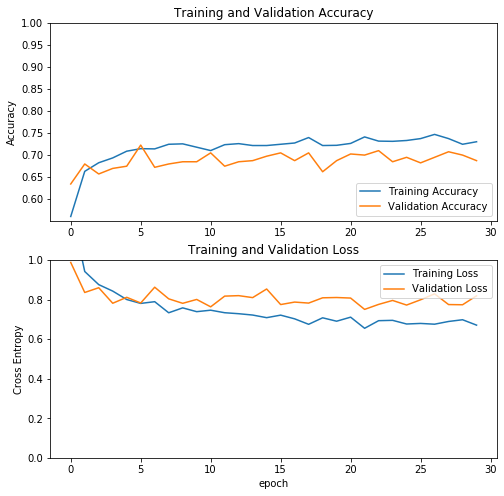

In [127]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [140]:
t = time.time()

export_path = r"tmp\saved_models\{}_valacc{}perc_{}".format(int(t),int(np.mean(val_acc)*100),"mobilenetv2")
model.save(export_path)

INFO:tensorflow:Assets written to: tmp\saved_models\1604894586_valacc68perc\assets


INFO:tensorflow:Assets written to: tmp\saved_models\1604894586_valacc68perc\assets
